# Table of contents


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpat
import matplotlib.transforms as trans
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
## user defined variables ##
region="TWP"
r=0.1 # 0=native grid, 0.1=0.1deg regridded
## determine what to plot 
## options: 'density', 'mean', 'median', 'diff' (to do)
plot_type = "diff"
var_type=None
dask_chunks={"ncol":1000, "Xdim":500}


# Plot joint histogram

In [3]:
# models = ["CCCM","ARP","GEOS","ICON","IFS","MPAS","SAM","SCREAM","SHiELD","UM"]
models = ["CCCM","ARP","ICON","IFS","MPAS","SAM","SHiELD","UM"]
# models = ["CCCM","MPAS"]


In [4]:
# olr = ap.load_olr("MPAS",region,r) #xtime, nCells
# alb = ap.load_alb("MPAS",region,r)
# olr, alb

In [5]:
# alb = alb.where(alb.time.dt.hour<=4)
# olr.mean(axis=(1)).plot()

In [15]:
np.logspace(-2,0,5)


array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ])

CCCM TWP
False
	olr (15352,), alb (15352,)
diff
(7562,)
starting plot...
... plotting difference
difference
7562
7289
... done plotting CCCM .
ARP TWP
False
[########################################] | 100% Completed | 911.44 ms
	olr (2880, 100, 101), alb (2880, 100, 101)
... dy1 getting sw for ARP
[########################################] | 100% Completed | 101.37 ms
... got sw
... got alb
... got olr
diff
coarsened to  (2977, 33, 33) (2977, 33, 33) (2880, 33, 33) (2880, 33, 33)
[########################################] | 100% Completed | 203.75 ms
[########################################] | 100% Completed | 829.55 ms
(653400,)
[########################################] | 100% Completed | 203.69 ms
[########################################] | 100% Completed | 305.85 ms
starting plot...
... plotting difference
difference
653400
676269
... done plotting ARP .
ICON TWP
False
[########################################] | 100% Completed | 302.63 ms
[######################################

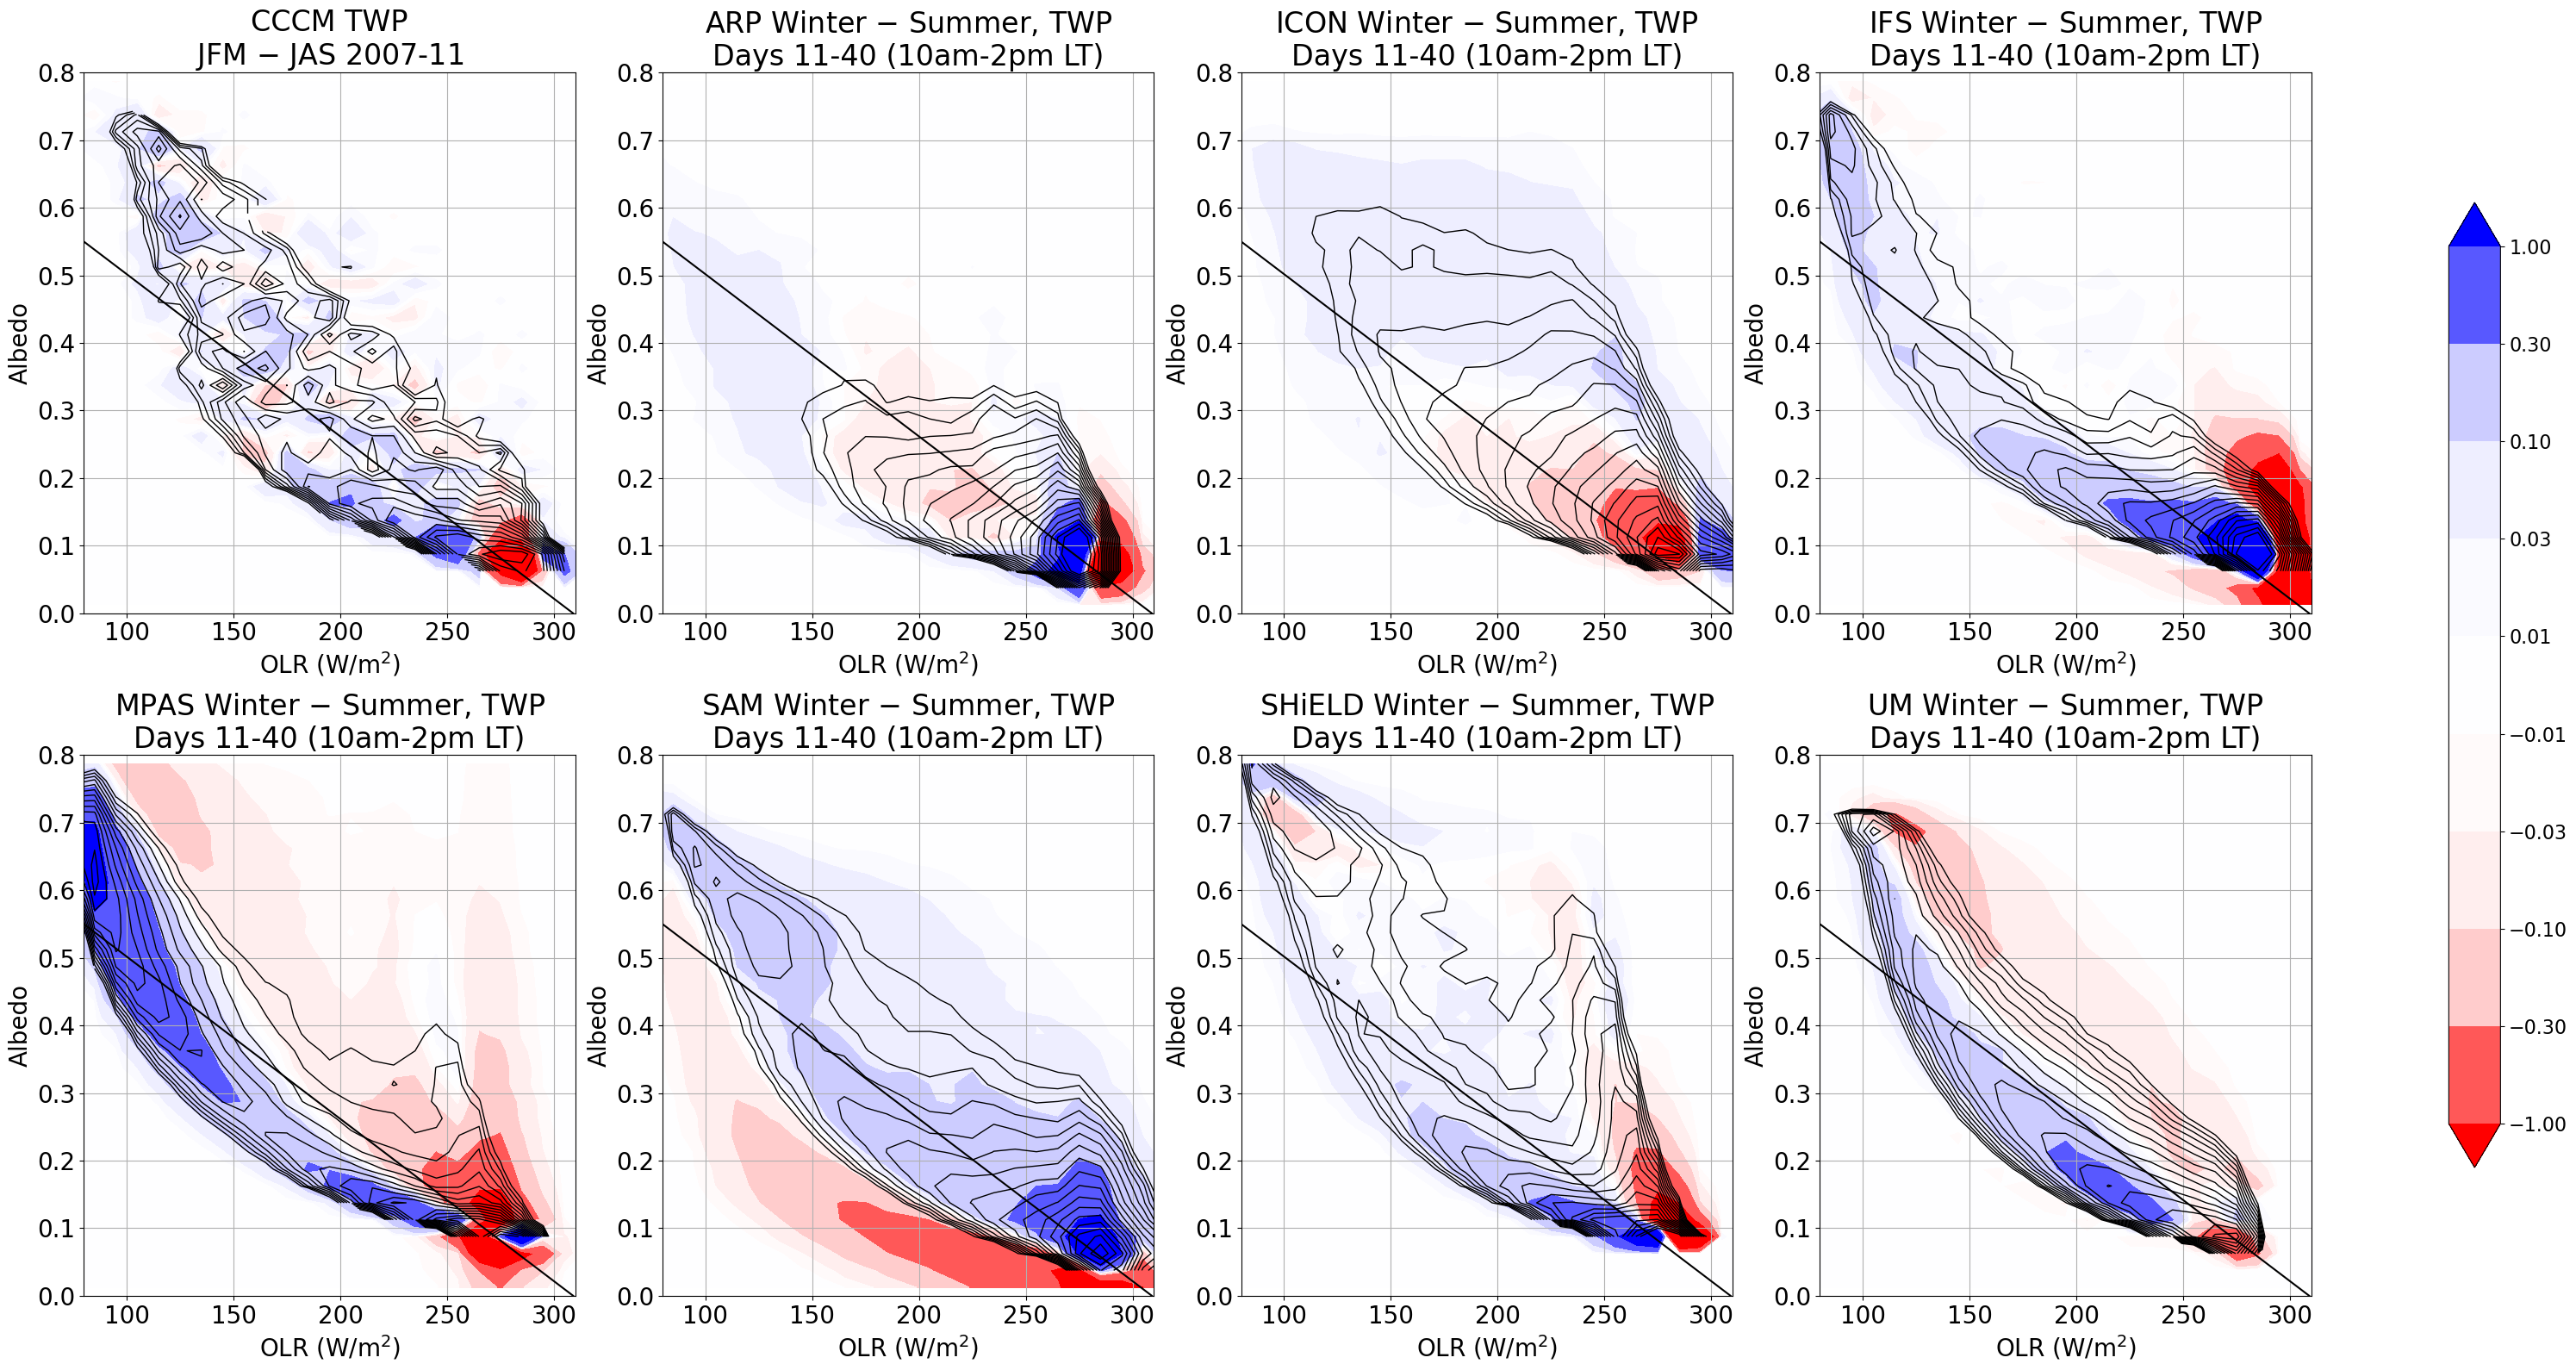

In [16]:
fig = plt.figure(figsize=(30,16))

for i, m in enumerate(models):
    print(m, region)
    ax = fig.add_subplot(2,int(len(models)/2), i+1, box_aspect=1.1)
    if m=="schematic":
        schematic(ax=ax, arrow=False)
    elif m is None:
        ax.axis("off")
        continue
    else:
        # load olr and albedo
        # to do - change hours (10-14) for non-TWP region
        if plot_type!="summer":
            olr = ap.load_olr(m,region,r)
            olr = olr.where((olr.time.dt.hour<=4))
            alb = ap.load_alb(m,region,r)
            alb = alb.where(alb.time.dt.hour<=4)
            print("\tolr {}, alb {}".format(olr.shape, alb.shape))
        if plot_type=="diff":
            if m[:2]=="SH":
                m1 = "FV3"
            else:
                m1=m
            olr1, alb1 = ap.load_olr_alb_dy1(m1, region)
            print('diff')
        elif plot_type=="summer":
            if m[:2]=="SH":
                m1 = "FV3"
            else:
                m1=m
            olr1, alb1 = ap.load_olr_alb_dy1(m1, region)
            print('summer')
        else:
            olr1=0 # anything but None
        # plotting variable values on olr-alb plane
        if (plot_type!="density") and (plot_type!="diff") and (plot_type!="summer"):
            if m=="UM":
                olr=olr[:680]
                alb=alb[:680]
                if var_type=="ts":
                    var = xr.open_dataset(ap.get_file(m, region, "ts")).ts[:,0]
                elif var_type=="cpt":
                    var = ap.load_3dvar(m,region,"ta",chunks=dask_chunks)
                    zg = ap.load_height_full(m, chunks=dask_chunks)
                    print("3d var, ta & zg:", var.shape, zg.shape)
                    # cold point tropopause temperature
                    var = var.where((zg<=18000)).min(dim='lev')
                var = var.where(var<1e10)
            else:
                if var_type=="ts":
                    var = xr.open_dataset(ap.get_file(m+"r"+str(r)+"deg", region, "ts")).ts
                elif var_type=="cpt":
                    var = ap.load_3dvar(m,region,"ta",chunks=dask_chunks)
                    zg = ap.load_height_full(m, chunks=dask_chunks)
                    print("3d var, ta & zg:", var.shape, zg.shape)
                    # cold point tropopause temperature
                    var = var.where((zg<=18000)).min(dim='lev')
            if var.time[0] != olr.time[0]:
                var = var[1:len(olr.time)+1]
            else:
                var = var[:len(olr.time)]
            print("\t", olr.shape, alb.shape, var.shape)
            olr = olr.sel(time=var.time)
            alb = alb.sel(time=olr.time)
            # var = var.sel(time=olr.time)
            print("\t", olr.shape, alb.shape)
            print("\t means", np.nanmean(olr), np.nanmean(alb))
            # print(var)

        # coarsen step to 0.3 deg (or n * r)
        if r>0:
            n=3 #0.1*n = coarsened resolution
            if m=="CERES" or m=="CCCM":
                pass
            elif m=="UM" and plot_type!="summer":
                olr = olr.coarsen(latitude=n, longitude=n, boundary='trim').mean() 
                alb = alb.coarsen(latitude=n, longitude=n, boundary='trim').mean()
                if (plot_type!="density") and (plot_type!="diff"):
                    var = var.coarsen(latitude=int(214/100)*n, longitude=int(142/100)*n, boundary='trim').mean() 
                    print("\tvar",var.shape, np.nanmean(var), np.nanstd(var))
            else:
                if plot_type!="summer":
                    olr = olr.coarsen(lat=n, lon=n, boundary='trim').mean() 
                    alb = alb.coarsen(lat=n, lon=n, boundary='trim').mean()
                if plot_type =="diff" or plot_type=="summer":
                    if olr1 is not None:
                        olr1 = olr1.coarsen(lat=n, lon=n, boundary='trim').mean()
                        alb1 = alb1.coarsen(lat=n, lon=n, boundary='trim').mean()
                        print("coarsened to ", olr1.shape, alb1.shape, olr.shape, alb.shape)
                elif (plot_type!="density"):
                    var = var.coarsen(lat=n, lon=n, boundary='trim').mean()
                    print("\tvar",var.shape, np.nanmean(var), np.nanstd(var))
        else:
            n=0
        
        # plot 
        # to do - add "diff" option
        if olr is None and plot_type!="summer":
            ax.axis("off")
            print('DY2 is NONE')
        elif olr1 is None:
            ax.axis("off")
            print('DY1 is NONE')
        else:
            if plot_type!="summer":
                olr = olr.values.flatten()
                alb = alb.values.flatten()
                alb = alb[~np.isnan(olr)]
                olr = olr[~np.isnan(olr)]
                print(olr.shape)
            if plot_type=="diff" or plot_type=="summer":
                olr1 = olr1.values.flatten()
                alb1 = alb1.values.flatten()
                alb1 = alb1[~np.isnan(olr1)]
                olr1 = olr1[~np.isnan(olr1)]
            elif (plot_type!="density"):
                var = var.values.flatten()
                var = var[~np.isnan(olr)]

            print("starting plot...")
            if plot_type=="density":
                _, im = util.dennisplot("density",olr, alb, 
                                ax=ax, model=m, region=region,
                                cmap="gist_earth_r", 
                                levels=np.arange(-3.4,-1.2,0.2), colorbar_on=False)
            elif plot_type=="diff":
                print("... plotting difference")
                _, im, cs = util.dennisplot("difference",(olr,olr1), (alb,alb1), 
                                ax=ax, model=m, region=region, levels=np.array([-1., -0.3, -0.1, -0.03, -0.01, 0.01, 0.03, 0.1, 0.3,  1.]),
                                cmap="bwr_r", colorbar_on=False, contour_one=True)
            elif plot_type=="summer":
                _, im = util.dennisplot("density",olr1, alb1, 
                                ax=ax, model=m, region=region+"(Summer)",
                                cmap="gist_earth_r", 
                                levels=np.arange(-3.4,-1.2,0.2), colorbar_on=False)
            else:
                print("plot_type", plot_type)
                if var_type=="ts":
                    print("ts")
                    if plot_type=="std":
                        print("test")
                        util.dennisplot(plot_type, olr, alb, var,
                                ax=ax, model=m, region=region,
                                cmap="rainbow", 
                                levels=np.arange(0,2,0.1),
                                colorbar_on=True)
                    else:
                        util.dennisplot(plot_type, olr, alb, var,
                                ax=ax, model=m, region=region,
                                cmap="rainbow", 
                                levels=np.arange(300,304,0.1),
                                colorbar_on=True)
                elif var_type=="cpt":
                    util.dennisplot(plot_type, olr, alb, var,
                                ax=ax, model=m, region=region,
                                cmap="rainbow", 
                                levels=np.arange(189,194,0.2),
                                colorbar_on=True)
    
            ax.set_xlabel("OLR (W/m$^2$)")
            ax.set_ylabel("Albedo")
            ax.grid(True)
            ax.set_ylim([0,0.8]) # [0.04,0.8]
            ax.set_xlim([80,310])
            if i==0:
                ax.set_title("{} {}\nJFM $-$ JAS 2007-11".format(m, region), 
                              fontsize=24)  
            elif plot_type=="diff":
                ax.set_title("{} Winter $-$ Summer, {}\nDays 11-40 (10am-2pm LT)".format(m, region), 
                              fontsize=24)
            else:
                ax.set_title("{} {}\nDays 11-40 (10am-2pm LT)".format(m, region), 
                              fontsize=24)
            # ax.scatter(np.nanmean(olr), np.nanmean(alb), color='r', s=50)
        print('... done plotting',m, '.')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=16)

save_name = "../plots/{}/jhist_{}_{:.2f}_{}_contours_logcmap.png".format(region, plot_type, r*n, region)
print("... saved as "+save_name)
plt.savefig(save_name)
plt.show()



1


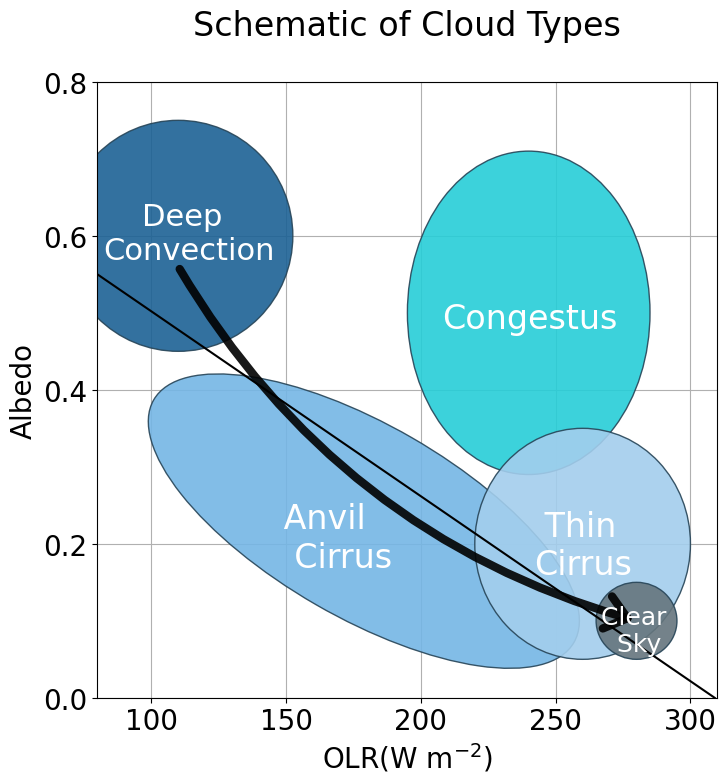

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
util.schematic(ax=ax, )
# ax.set(xlim=[0,1])
plt.savefig("../plots/TWP/jhist_schematic.png")
plt.show()

# Debugging

## single variable

In [26]:
m="MPAS"
r=0.1
region="TWP"

olr = ap.load_olr(m,region,r)
alb = ap.load_alb(m,region,r)

if m=="UM":
    var = xr.open_dataset(ap.get_file(m, region, "ts")).ts[:,0]
    var = var.where(var<1e10)
    print(olr.shape, alb.shape, var.shape)
else:
    var = xr.open_dataset(ap.get_file(m+"r"+str(r)+"deg", region, "ts")).ts

[########################################] | 100% Completed |  1.8s


In [23]:
print(np.nanmean(var), np.nanstd(var), np.nanmin(var), np.nanmax(var))
var.shape, olr.shape

302.45374 0.86048144 290.63077 320.2812


((2976, 100, 101), (2879, 100, 101))

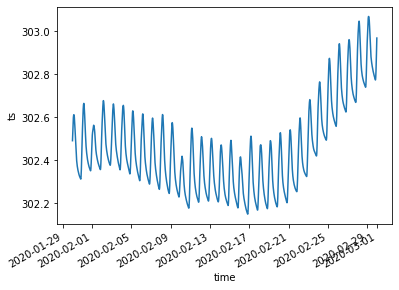

[########################################] | 100% Completed |  0.1s


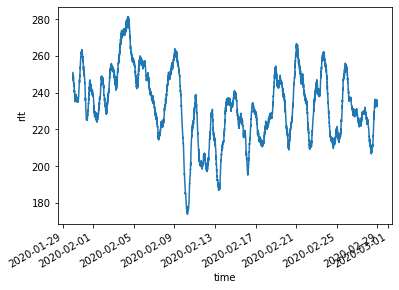

[########################################] | 100% Completed |  1.9s


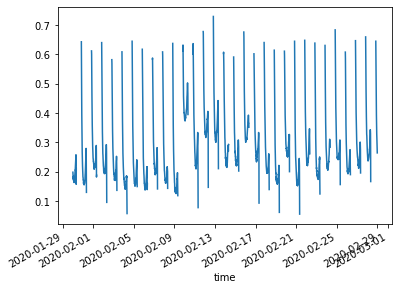

In [27]:
var.mean(axis=(1,2)).plot()
plt.show()
olr.mean(axis=(1,2)).plot()
plt.show()
alb.mean(axis=(1,2)).plot()
plt.show()

## get TTL mean temperature

In [3]:
m="SCREAM"
r=0
region="TWP"
dask_chunks={"time":50,"ncol":500}

olr = ap.load_olr(m,region,r)
var = ap.load_3dvar(m,region,"ta",chunks=dask_chunks)
print(var.shape)

zg = ap.load_height_full(m, chunks=dask_chunks)
print(zg.shape)

# mean ttl temperature
var_ttl = var.where((zg>=14000)&(zg<=18000)).mean(dim='lev')
var_ttl.mean(dim='ncol').plot()

# cold point tropopause temperature
var_cpt = var.where((zg<=18000)).min(dim='lev')
var_cpt.mean(dim='ncol').plot()

## single model analysis

-228.98619 0.22368805
7289


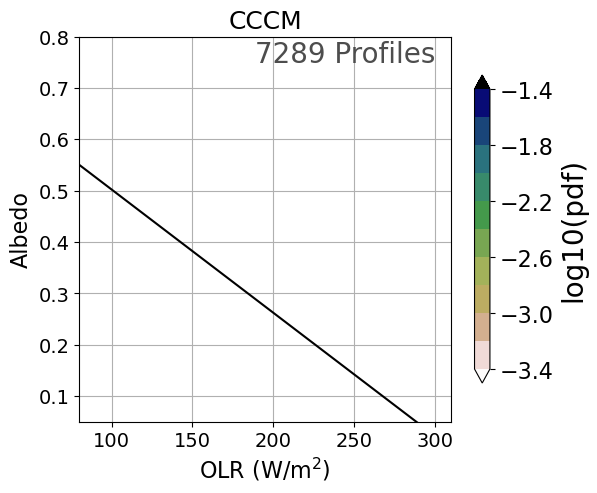

In [11]:
m="CCCM"
fs=18
fig, axes = plt.subplots(1,1, figsize=(6,5))

olr, alb = ap.load_olr_alb_dy1(m, "TWP")
olr=-olr
# olr = ap.load_olr(m, "TWP", r=0.1)
# alb = ap.load_alb(m, "TWP", r=0.1, near_noon=True)
# olr = olr.where((olr.time.dt.hour>=0)&(olr.time.dt.hour<=4))
# alb = alb.where((alb.time.dt.hour>=0)&(alb.time.dt.hour<=4))
print(np.nanmean(olr), np.nanmean(alb))
util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                ax=axes, model=m, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), colorbar_on=True)
axes.set_xlabel("OLR (W/m$^2$)", fontsize=fs-2)
axes.set_ylabel("Albedo", fontsize=fs-2)
axes.tick_params(axis="both", labelsize=fs-4)
axes.grid(True)
axes.set_title(m, fontsize=fs)
plt.savefig("../plots/TWP/jhist_dy1_{}r0.1deg.png".format(m), dpi=150)
plt.show()

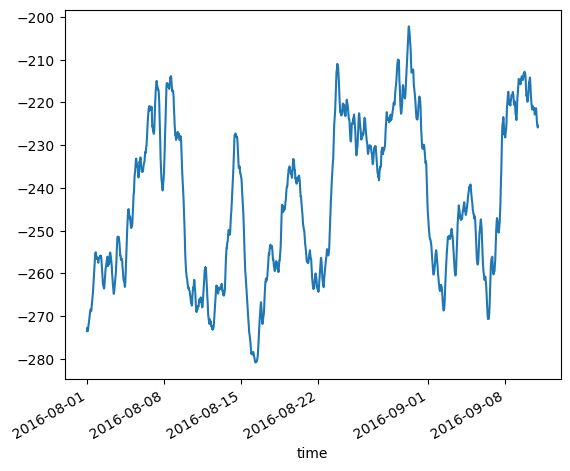

In [54]:
# undo running mean of ICON from DY1


def undo_mean(meanarray):
    data = np.zeros(np.shape(meanarray))
    data[0] = meanarray[0] # they both will be zero
    data[1] = meanarray[1] # this is the actual first data point... 

    # loop forward through the rest of the indices in array to "undo" the "mean from model start"
    for i in np.arange(2,np.shape(meanarray)[0]):
        data[i] = (i+1)*meanarray[i] - i*meanarray[i-1]
    data = xr.DataArray(data, dims=meanarray.dims, coords=meanarray.coords)
    return data


swn = xr.open_dataset(ap.TWP1+"TWP_ICON_rst_20160801-20160910.nc").rst
swu = xr.open_dataset(ap.TWP1+"TWP_ICON_rsut_20160801-20160910.nc").rsut
olr = xr.open_dataset(ap.TWP1+"TWP_ICON_ATHB_T_20160801-20160910.nc").ATHB_T

swn.mean(axis=(1,2)).plot()
swu.mean(axis=(1,2)).plot()
olr.mean(axis=(1,2)).plot()
plt.show()

swn_unacc = undo_mean(swn)
swu_unacc = undo_mean(swu)
olr_unacc = undo_mean(olr)
swn_unacc.mean(axis=(1,2)).plot()
swu_unacc.mean(axis=(1,2)).plot()
olr_unacc.mean(axis=(1,2)).plot()
plt.show()
olr_unacc[0] = np.nan
olr_unacc[193]= np.nan
olr_unacc.mean(axis=(1,2)).plot()
plt.show()

ds_olr = xr.Dataset({"rlt":olr_unacc}, 
                    attrs={"long_name":"outgoing longwave radiation at TOA (undone mean)","units":"W/m2"})
ds_swu = xr.Dataset({"rsut":swu_unacc}, 
                    attrs={"long_name":"outgoing shortwave radiation at TOA (undone mean)","units":"W/m2"})
ds_swn = xr.Dataset({"rlt":swn_unacc}, 
                    attrs={"long_name":"net shortwave radiation at TOA (undone mean)","units":"W/m2"})
print(ds_swn)
# ds_olr.to_netcdf(ap.TWP1+"TWP_ICON_rlt_20160801-20160910.nc")
# ds_swu.to_netcdf(ap.TWP1+"TWP_ICON_rsut_20160801-20160910.nc")
# ds_swn.to_netcdf(ap.TWP1+"TWP_ICON_rst_20160801-20160910.nc")

<xarray.Dataset>
Dimensions:  (time: 3937, lon: 100, lat: 100)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-01T00:15:00 ... 2016-09-11
  * lon      (lon) float64 143.1 143.2 143.3 143.4 ... 152.7 152.8 152.9 153.0
  * lat      (lat) float64 -4.95 -4.85 -4.75 -4.65 -4.55 ... 4.65 4.75 4.85 4.95
Data variables:
    rlt      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 989.0 986.5 978.0
Attributes:
    long_name:  net shortwave radiation at TOA (undone mean)
    units:      W/m2

[########################################] | 100% Completed |  0.2s


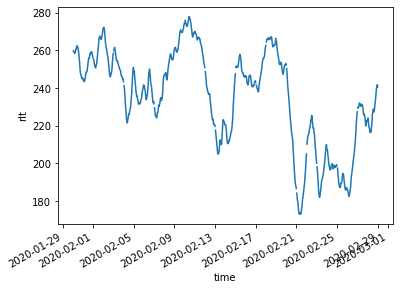

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


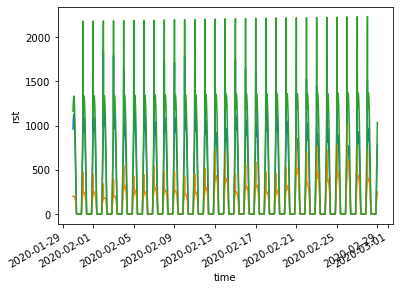

In [20]:
olrs["ICON"].mean(axis=(1,2)).plot()
plt.show()
ic_swn.mean(axis=(1,2)).plot()
ic_swu.mean(axis=(1,2)).plot()
ic_swd.mean(axis=(1,2)).plot()
plt.show()

In [24]:
ic_olr.mean(axis=(1,2))[84].values

[########################################] | 100% Completed |  0.2s


array(245.27, dtype=float32)

In [25]:
ic_olr.min().values, ic_olr.max().values, ic_alb.min().values, ic_alb.max().values

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


(array(65.528885, dtype=float32),
 array(326.6667, dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32))

In [26]:
# print("DATA:   " + str(int(da_olr.mean().values)) + "   " + str(da_alb.where(da_alb.time.dt.hour<4).mean().values)+\
#       "\nNICAM:  " + str(int(ni_olr.mean().values)) + "   " + str(ni_alb.where(ni_alb.time.dt.hour<4).mean().values)+\
#       "\nSAM:    " + str(int(sa_olr.mean().values)) + "   " + str( sa_alb.where(sa_alb.time.dt.hour<4).mean().values)+\
#       "\nUM:     " + str(int(um_olr.mean().values)) + "   " + str(um_alb.where(um_alb.time.dt.hour<4).mean().values)+\
#       "\nGEOS:   " + str(int(ge_olr.mean().values)) + "   " + str(ge_alb.where(ge_alb.time.dt.hour<4).mean().values)+\
#       "\nSCREAM  " + str(int(sc_olr.mean().values)) + "   " + str(sc_alb.where(sc_alb.time.dt.hour<4).mean().values)
#      )


# CCCM data dyamond 1 vs 2

In [27]:
16.2/3

5.3999999999999995

## density plots for obs


0 JFM
7562
1 JAS
7289
difference
7562
7289


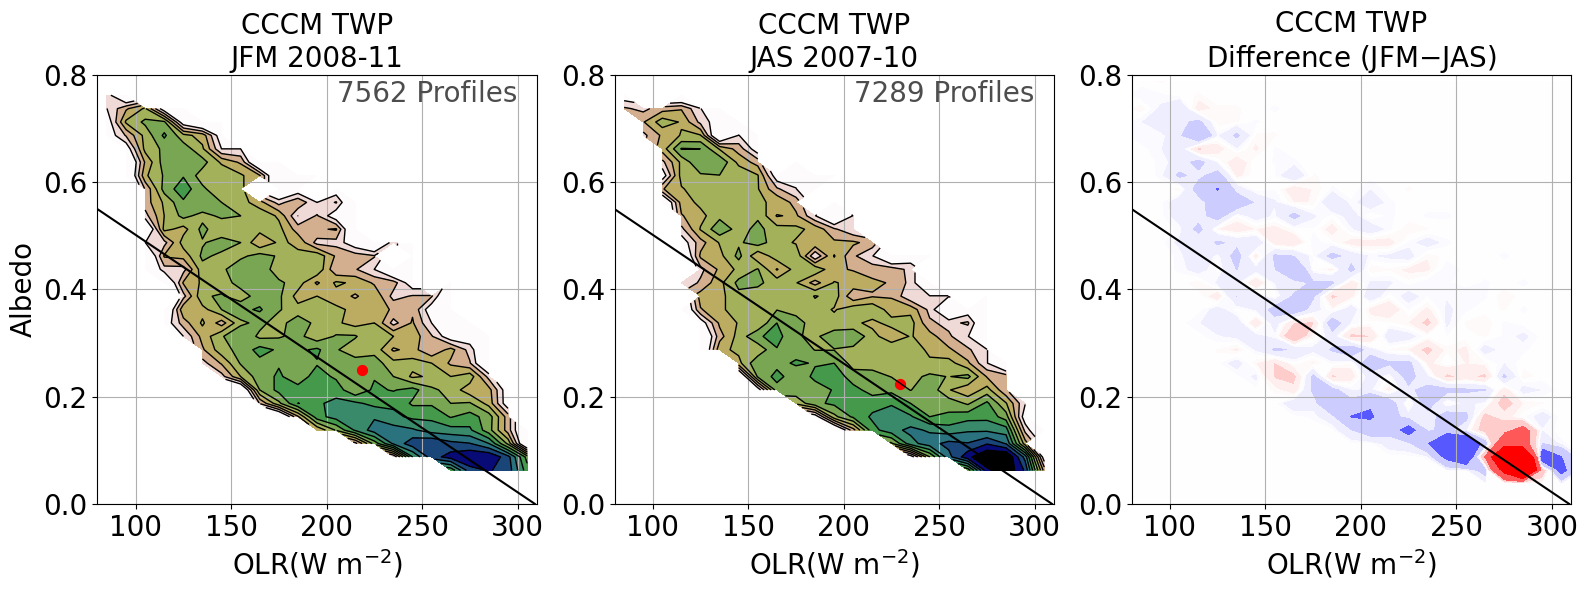

In [17]:
ds_dict = {"JAS":xr.open_dataset(ap.CCCM_JAS), "JFM":xr.open_dataset(ap.CCCM_JFM)}

fig = plt.figure(figsize=(16,6))
axes = [fig.add_subplot(1,3,i) for i in range(1,4)]
cb=False
olr_szn = {}
alb_szn = {}

for i, season in enumerate(["JFM","JAS","diff"]):
    if season=="diff":
        util.dennisplot("difference", (olr_szn["JFM"],olr_szn["JAS"]),
                        (alb_szn["JFM"],alb_szn["JAS"]), ax=axes[i], 
                        model="CCCM", region=region, cmap="bwr_r",
                        colorbar_on=cb, levels=np.array([-1., -0.3, -0.1, -0.03, -0.01, 0.01, 0.03, 0.1, 0.3,  1.]))
        axes[i].set_title("CCCM {}\nDifference (JFM$-$JAS)".format(region), fontsize=20)
        axes[i].set(ylim=[0,0.8])
    else:
        print(i, season)
        olr = ds_dict[season].CERES_LW_TOA_flux___upwards
        swu = ds_dict[season].CERES_SW_TOA_flux___upwards
        swd = ds_dict[season].TOA_Incoming_Solar_Radiation
        alb = swu/swd
        
        olr_szn[season] = olr.values
        alb_szn[season] = alb.values

        olr = olr[~np.isnan(alb)]
        alb = alb[~np.isnan(alb)]
        alb = alb[~np.isnan(olr)]
        olr = olr[~np.isnan(olr)]
        
        util.dennisplot("density",olr.values, alb.values, 
                        ax=axes[i], model="CCCM", region=region, 
                        cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), colorbar_on=cb)
        if season=="JAS":
            axes[i].set_title("CCCM {}\nJAS 2007-10".format(region), fontsize=20)
        else:
            axes[i].set_title("CCCM {}\nJFM 2008-11".format(region), fontsize=20)
        axes[i].scatter(np.nanmean(olr), np.nanmean(alb), color='r', s=50)
        axes[i].set(ylim=[0,0.8])
axes[1].set(ylabel="")
axes[2].set(ylabel="")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig("../plots/TWP/jhist_dy1v2_CCCM_logcmap.png".format(region),dpi=200)
plt.show()

## difference plot

In [ ]:
ds_dict = {"JAS":xr.open_dataset(ap.CCCM_JAS)}
ds_dict["JFM"] = xr.open_dataset(ap.CCCM_JFM)
seasons = ["JAS","JFM"]

olrs={}
albs={}

for season in seasons:
    olrs[season] = ds_dict[season].CERES_LW_TOA_flux___upwards
    swu = ds_dict[season].CERES_SW_TOA_flux___upwards
    swd = ds_dict[season].TOA_Incoming_Solar_Radiation
    albs[season] = swu/swd.values

fig, ax = plt.subplots(1,1,figsize=(7,6))

util.dennisplot("difference",
                [olrs["JAS"].values,olrs["JFM"].values], 
                [albs["JAS"].values,albs["JFM"].values], 
                ax=ax, model="CCCM 20km", region=region, 
                cmap="bwr", levels=np.arange(-0.9,1,0.2),
                colorbar_on=True)

ax.set_xlabel("OLR (W/m$^2$)")
ax.set_ylabel("Albedo")
ax.grid(True)
ax.set_ylim([0,0.8])
ax.set_title("CCCM 20km {}\nJAS-JFM 2007-10".format(region), 
              fontsize=20)  
# ax.plot([np.nanmean(olrs["JAS"]),np.nanmean(olrs["JFM"])], 
#         [np.nanmean(albs["JAS"]),np.nanmean(albs["JFM"])], 
#         color='r',marker=".",markersize=20,linewidth=5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig("../plots/TWP/jhistCCCM_{}_difference.png".format(region))
plt.show()

# DYAMOND 1 v 2 

- density
- difference


In [3]:
def undomean(meanarray):
    new = xr.DataArray(np.zeros(meanarray.shape), dims=meanarray.dims, coords=meanarray.coords)
    new[1]=meanarray[1]
    for i in np.arange(2,np.shape(meanarray)[0]):
        new[i,:,:] = (i+1)*meanarray[i,:,:] - i*meanarray[i-1,:,:]
    new[0]=np.nan
    new[192]=np.nan
    return new


In [5]:
m="IFS"

if m=="ARP":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:,0].interp({"time":summer_swn.time, 
                                                                     "lat":summer_swn.lat, 
                                                                     "lon":summer_swn.lon}, 
                                                                    method="nearest")
    summer_swu = summer_swd.values - summer_swn
elif m=="SAM" or m=="GEOS":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:,0].interp({"time":summer_swn.time, 
                                                                     "lat":summer_swn.lat, 
                                                                     "lon":summer_swn.lon}, 
                                                                    method="nearest")
    summer_swu = summer_swd.values - summer_swn
elif m=="ICON":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swu = ap.open_dyamond1(m,"TWP","rsut").rsut
    print(summer_olr.shape, summer_swn.shape, summer_swu.shape)
    summer_olr = undomean(summer_olr)
    summer_swn = undomean(summer_swn)
    summer_swu = undomean(summer_swu)
    summer_swd = summer_swu.values + summer_swn
    summer_swu = summer_swu.sel(time=summer_olr.time)
    summer_swd = summer_swd.sel(time=summer_olr.time)
    print(summer_olr.shape, summer_swn.shape, summer_swu.shape)
elif m=="FV3":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt #olr
    summer_swu = ap.open_dyamond1(m,"TWP","rsut").rsut
    summer_swd = ap.open_dyamond1(m,"TWP","rsdt").rsdt
elif m=="MPAS":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt.rename({"xtime":"time"})
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst.rename({"xtime":"time"})
    summer_swn['time'] = summer_swn.time.astype('datetime64[ns]')
    summer_olr['time'] = summer_olr.time.astype('datetime64[ns]')
    print(summer_olr)
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:2977,0]#.sel(time=summer_swn.xtime.astype("datetime64[ns]"))
    print(summer_swd.shape, summer_swn.shape, summer_swd.time[0].values, summer_swn.time[0].values, summer_swd.time[-1].values, summer_swn.time[-1].values)
    summer_swu = summer_swd.values - summer_swn
elif m=="IFS":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:,0].sel(time=summer_swn.time)
    summer_swu = summer_swd.values - summer_swn
else:
    summer_olr = ap.open_dyamond1(m,"TWP","rlut").rlut
    summer_swu = ap.open_dyamond1(m,"TWP","rsut").rsut
    summer_swd = ap.open_dyamond1(m,"TWP","rsdt").rsdt
summer_alb = summer_swu/summer_swd.where(summer_swd>500).values

############################
### winter
if m=="FV3":
    m="SHiELD"

winter_olr = ap.load_olr(m,region,r)
winter_alb = ap.load_alb(m,region,r)

summer_olr.shape, summer_alb.shape, winter_olr.shape, winter_alb.shape

False


Exception: model or region not defined properly. Try 'TWP' or 'SCREAM', 'UM', 'GEOS', etc.

In [25]:
# summer_olr_new.mean(axis=(1,2)).plot()
# # summer_olr.mean(axis=(1,2)).plot()
# plt.show()

# fig = plt.figure(figsize=(8,7))
# util.dennisplot("density",
#                 # summer_olr.where(summer_olr.time.dt.hour<=4).values.flatten(), 
#                 # summer_alb.where(summer_alb.time.dt.hour<=4).values.flatten(), 
#                 summer_olr,
#                 summer_alb,
#                 model="10 Aug$-$10 Sept 2016 "+m, region=region, 
#                 cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
#                 colorbar_on=True)
# plt.show()
np.nanmean(summer_alb), np.nanmin(summer_alb), np.nanmax(summer_alb)

(0.22463538, 0.038178235, 0.8535869)

In [26]:
winter_olr = winter_olr.where((winter_olr.time.dt.hour<=4)).values.flatten()
winter_alb = winter_alb.where(winter_alb.time.dt.hour<=4).values.flatten()
if m=="SAM":
    summer_olr = summer_olr.where((summer_olr.time.dt.hour<=6)&(summer_olr.time.dt.hour>=2)).values.flatten()
    summer_alb = summer_alb.where((summer_alb.time.dt.hour<=6)&(summer_alb.time.dt.hour>=2)).values.flatten()
# elif m=="MPAS":
    # summer_olr = summer_olr.where((summer_olr.xtime.astype('datetime64[ns]').dt.hour<=4)).values.flatten()
    # summer_alb = summer_alb.where((summer_alb.xtime.astype('datetime64[ns]').dt.hour<=4)).values.flatten()
    # summer_olr = summer_olr.values.flatten()
    # summer_alb = summer_alb.values.flatten()
else:
    summer_olr = summer_olr.where((summer_olr.time.dt.hour<=4)).values.flatten()
    summer_alb = summer_alb.where((summer_alb.time.dt.hour<=4)).values.flatten()



[########################################] | 100% Completed | 201.74 ms
[########################################] | 100% Completed | 205.77 ms


In [27]:
summer_olr.shape, summer_alb.shape, winter_olr.shape, winter_alb.shape

((29770000,), (29770000,), (29088000,), (29088000,))

## Density plot side by side

11174115
6060000


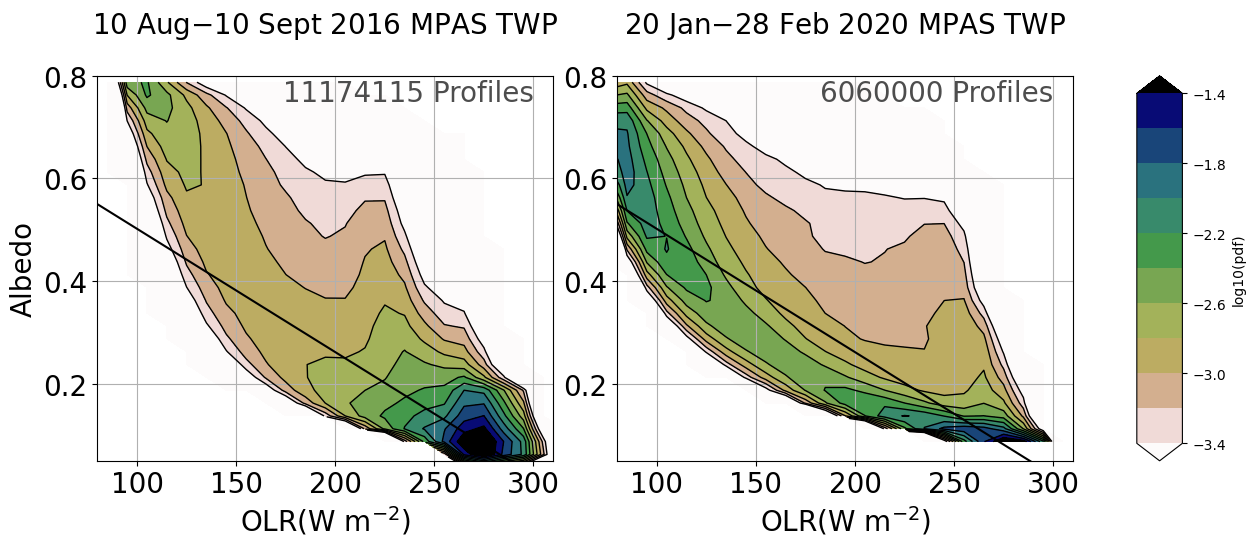

In [29]:
fig, ax = plt.subplots(1,3, figsize=(14,5), gridspec_kw={'width_ratios': [5, 5, 0.5]})
util.dennisplot("density",
                summer_olr, 
                summer_alb, model="10 Aug$-$10 Sept 2016 "+m, region=region, 
                ax=ax[0],
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
                colorbar_on=False)
_, im = util.dennisplot("density",
                winter_olr, 
                winter_alb, model="20 Jan$-$28 Feb 2020 "+m, region=region, 
                ax=ax[1],
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
                colorbar_on=False)
plt.colorbar(im, cax=ax[2], label="log10(pdf)")
ax[1].set(ylabel="")
plt.savefig("../plots/TWP/jhist_dy1v2_{}_cbar.png".format(m),dpi=200)
plt.show()

## Difference plot (summer - winter)

difference
11174115
6060000


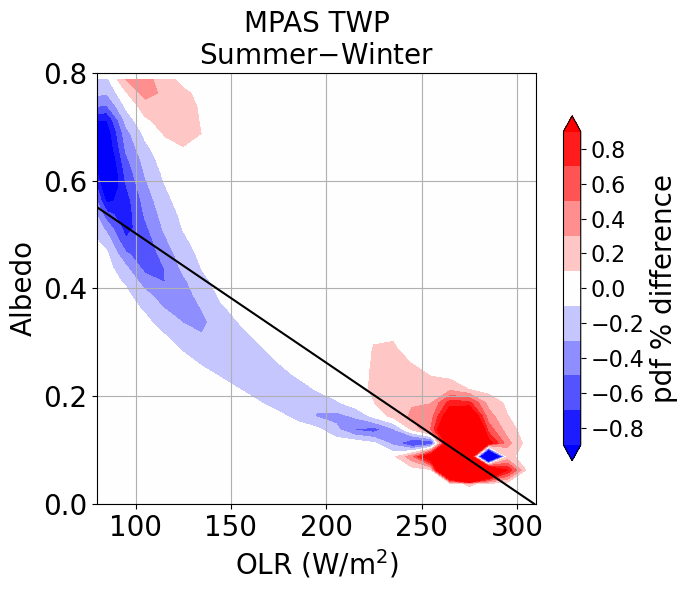

In [30]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

util.dennisplot("difference",
                [summer_olr, winter_olr], 
                [summer_alb, winter_alb], 
                ax=ax, model=m, region=region, 
                cmap="bwr", levels=np.arange(-0.9,1,0.2),
                colorbar_on=True)

ax.set_xlabel("OLR (W/m$^2$)")
ax.set_ylabel("Albedo")
ax.grid(True)
ax.set_ylim([0,0.8])
ax.set_title("{} {}\nSummer$-$Winter".format(m, region), 
              fontsize=20)  
# ax.plot([np.nanmean(olrs["JAS"]),np.nanmean(olrs["JFM"])], 
#         [np.nanmean(albs["JAS"]),np.nanmean(albs["JFM"])], 
#         color='r',marker=".",markersize=20,linewidth=5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig("../plots/TWP/jhist_dy1v2_{}_{}_difference.png".format(m, region))
plt.show()

# GEOS high albedo high OLR values

In [ ]:
ge_iwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clivi", "TWP")).clivi
ge_lwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clwvi", "TWP")).clwvi
ge_iwp, ge_lwp  

In [ ]:
# t = 2867
# for t in range(t,t+25):
#     fig, ax = plt.subplots(2,2, figsize=(12,10))
    
#     ge_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
#     ge_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
#     ax[0,0].annotate("Mean OLR={}".format(int(ge_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[0,1].annotate("Mean Alb={0:0.2g}".format((ge_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

#     print(ge_olr[t].mean().values, ge_alb[t].mean().values)

#     ge_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0])
#     ge_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
#     ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((ge_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     plt.savefig("../plots/TWP/GEOS-albolriwplwp/g{0:0>4}.png".format(t))
#     plt.close()

# SCREAM weird olr alb values


In [ ]:
sc_iwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clivi")).clivi
# sc_lwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clwvi")).clwvi
sc_iwp#, sc_lwp

In [ ]:
t = 300

# for t in range(t,t+1):
fig, ax = plt.subplots(2,2, figsize=(12,10))

sc_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
sc_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
ax[0,0].annotate("Mean OLR={}".format(int(sc_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
ax[0,1].annotate("Mean Alb={0:0.2g}".format((sc_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

print(ge_olr[t].mean().values, ge_alb[t].mean().values)
# levs = np.logspace(-9,1,25)
# levs = np.linspace(-5,1,12)
sc_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0]) #  
ax[1,0].set_title(sc_iwp[t].time.values)
# sc_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((sc_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
# ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
plt.savefig("../plots/TWP/SCREAM-albolriwplwp/s{0:0>4}.png".format(t))
plt.show()

In [ ]:
plt.hist2d(sc_iwp.values.flatten(), sc_olr.values.flatten(), density=True, 
           bins=[np.logspace(-7,2,25), np.linspace(80,310,26)])# np.linspace(0,1,26)])# 
plt.xscale('log')
plt.colorbar()
plt.show()

In [ ]:
sc_olr.shape, sc_alb.shape, sc_iwp.shape

In [ ]:
# util.dennisplot("mean",sc_olr.values.flatten(), sc_alb.values.flatten(), var=sc_iwp.values.flatten())

# GT TTL cld frac

In [ ]:
da = xr.open_dataset(ap.GT+"GT/